# Reformultating The Fixed Charge Network Flow

From the notes we know that we can reformulate the problems

\begin{align*}
\min &\sum_{(i,j)\in A} c_{ij} \sum_{t\in T} w_{ij}^t + q_{ij}x_{ij} \\
&\sum_{j\in V^{-}(r)} w_{jr}^t - \sum_{j\in V^+(r)} w_{rj}^t = -b_t, \qquad && t\in T\\
&\sum_{j\in V^{-}(r)} w_{ji}^t - \sum_{j\in V^+(r)} w_{ij}^t = 0, \qquad && i\in V\setminus \{r\}. t \in T, t \neq i\\
&\sum_{j\in V^{-}(r)} w_{jt}^t - \sum_{j\in V^+(r)} w_{tj}^t = b_t, \qquad && t\in T\\
& w_{ij}^t \leq b_tx_{ij} \qquad && (i,j)\in A, t\in T\\
& w_{ij}^t \geq 0, x_{ij} \in\{0,1\} \qquad && (i,j)\in A, t\in T
\end{align*}
Where
$ T = \{v\in V\setminus \{r\} : b_v > 0\}$

### By Anders G. Kristensen (tzk942) and Karl P. Nørgaard (cth443)

# 0: Initiation

### 0.1: Environment

In [ ]:
#Insert gurobi license to run
!pip install gurobipy
import gurobipy as gp
params = {
"WLSACCESSID": "",
"WLSSECRET":"",
"LICENSEID":
}
env = gp.Env(params=params)

### 0.2: Data

In [2]:
import random as r
import gurobipy as gp
from gurobipy import GRB, quicksum, Model
import matplotlib.pyplot as plt
import numpy as np
import time as t
import networkx as nx
import seaborn as sns

class FCNFP:
    '''
    This class represents the blueprint for instances of the Fixed Charge Network Flow Problem.
    The constructor generates random instances for of a given size. We also need to pass a seed which
    initializes the random number generator. Each value of the seed corresponds to a different instance of the problem.
    '''
    def __init__(self,n_nodes:int, seed:int):
        r.seed(seed)
        self.nodes = [i+1 for i in range(n_nodes)]
        self.arcs = [(i,j) for i in self.nodes for j in self.nodes if (i != 0) and (r.random() > 0.3)]
        self.flow_cost = {(i,j): 20 + 20 * r.random() for (i,j) in self.arcs}
        self.fixed_cost = {(i,j): 200 + 200 * r.random() for (i,j) in self.arcs}
        # We arbitrarilyy designate node 1 as the root
        self.demand = {i: int(50)+ r.randint(0,25) for i in self.nodes if i > 1}
        self.demand[1] = -sum(self.demand.values())

        # Create graph
        self.G = nx.DiGraph()
        for (i, j) in self.arcs:
            self.G.add_edge(i, j, flow_cost=self.flow_cost[(i, j)])

    #Reducing data by discarding arcs that can be immediately ruled out of any optimal solution

    def reduce_data(self):
        self.nodes_connected_to_root = {j for (i, j) in self.arcs if i == 1}
        self.nodes_connected_to_root_with_lowcost = {j for (i, j) in self.arcs if i == 1 and self.flow_cost[(i, j)] <= 36}

        self.nodes_not_connected_to_root = [i for i in self.nodes if i not in self.nodes_connected_to_root and i > 1]


        # Combine conditions to reduce arcs in one go
        self.arcs = [
        (i, j) for (i, j) in self.arcs if
        (i == 1 and j != 1) or
        (i != 1 and j != 1 and i != j and j not in self.nodes_connected_to_root_with_lowcost)
        ]

        self.arcs = [
        (i,j) for (i,j) in self.arcs if not (j in self.nodes_connected_to_root and i not in self.nodes_connected_to_root)
        or i==1]

        arcs_to_remove = []


        for i in list(self.nodes_connected_to_root)[1:]:
            for j in self.nodes_connected_to_root:
                if (i, j) in self.arcs:
                    # Calculate the sum of the flow costs
                    cost_sum = self.flow_cost[(1, i)] + self.flow_cost[(i, j)]

                    # Calculate the threshold
                    threshold = (self.fixed_cost[1,j] - self.fixed_cost[i,j]) / self.demand[j] + self.flow_cost[(1, j)]

                    # Check if the condition holds
                    if cost_sum > threshold:
                        arcs_to_remove.append((i, j))

        #Removing arcs
        for arc in arcs_to_remove:
            self.arcs.remove(arc)


        self.nodes_only_connected_to_root = {j for j in self.nodes_connected_to_root if all(i == 1 for (i, _) in self.arcs if _ == j)}

        self.two_way_arcs = [(i,j) for (i,j) in self.arcs if (j,i) in self.arcs and i < j]

        # Efficiently filter out arcs for flow_cost and fixed_cost
        arcs_set = set(self.arcs)
        self.flow_cost = {(i, j): cost for (i, j), cost in self.flow_cost.items() if (i, j) in arcs_set}
        self.fixed_cost = {(i, j): cost for (i, j), cost in self.fixed_cost.items() if (i, j) in arcs_set}

    #Finding best paths to each terminal in naïve problem with no fixed cost
    def compute_minimum_path_cost(self, target_node):
        shortest_path_length = nx.single_source_dijkstra_path_length(self.G, 1, weight='flow_cost')
        return shortest_path_length.get(target_node, float('inf'))

    #Computing total flow cost in naïve problem
    def compute_improved_lower_bound(self):
        improved_lower_bound = 0
        for node in self.nodes:
            if node != 1:  # Exclude the root
                min_path_cost = self.compute_minimum_path_cost(node)
                improved_lower_bound += self.demand[node] * min_path_cost
        return improved_lower_bound

    # Constructing a first-best heuristic solution
    def heuristic_solution(self):
        activated_arcs = set()

        for node in self.nodes:
            if node != 1:
                path = nx.single_source_dijkstra_path(self.G, 1, weight='flow_cost').get(node)
                if path:
                    # Extract arcs from the path
                    for i in range(len(path) - 1):
                        activated_arcs.add((path[i], path[i+1]))

        # Compute the objective for the heuristic solution
        fixed_costs_activated = sum([self.fixed_cost[arc] for arc in activated_arcs])
        heuristic_obj = fixed_costs_activated + self.compute_improved_lower_bound()

        return heuristic_obj, activated_arcs

# 1: Solving with Gurobi's inbuilt solver

### 1.1: Constructing model for inbuilt solver

In [3]:
class FCNFPSolver:
    def __init__(self, problem_instance:FCNFP):
        self.p = problem_instance
        self.m = gp.Model(env=env, name="FCNFP")
        self.x = None
        self.w = None
        self.runtime = None


    def build_model(self):
        #Defining variables, objective and constraints

        self.x = self.m.addVars(self.p.arcs, vtype=GRB.BINARY, name="x")

        self.w = self.m.addVars([(i,j,t) for (i,j) in self.p.arcs for t in self.p.nodes if t > 1],
                                lb= 0, ub= GRB.INFINITY,name="w")

        self.m.setObjective(quicksum([self.p.flow_cost[i,j] * self.w[i,j,t] for (i,j) in self.p.arcs
                                      for t in self.p.nodes if t > 1])
                                     + self.x.prod(self.p.fixed_cost))

        self.m.addConstrs(self.w.sum('*',1,t) - self.w.sum(1,'*',t) == -self.p.demand[t]
                          for t in self.p.nodes if t > 1)

        self.m.addConstrs(self.w.sum('*',i,t) - self.w.sum(i,'*',t) == 0
                          for i in self.p.nodes for t in self.p.nodes
                          if i > 1 and t >1 and i != t)

        self.m.addConstrs(self.w.sum('*',t,t) - self.w.sum(t,'*',t) == self.p.demand[t]
                          for t in self.p.nodes if t > 1)

        self.m.addConstrs(self.w[i,j,t] <= p.demand[t] * self.x[i,j]
                          for (i,j) in self.p.arcs for t in self.p.nodes if t > 1)

    #Defining solver w. timelimit

    def solve(self, time_limit_minutes = 2):
        self.m.Params.OutputFlag = 0
        self.m.Params.TimeLimit = 60 * time_limit_minutes
        self.m.optimize()
        self.runtime = self.m.Runtime

    #Retrieving arc_results if optimality is reached

    def print_arc_results(self):
        if self.m.status == GRB.OPTIMAL or self.m.status == GRB.SUBOPTIMAL:
            for i, j in self.p.arcs:
                x_value = self.x[i, j].X
                for t in [node for node in self.p.nodes if node > 1]:
                    w_value = self.w[i, j, t].X
                    print(f"Arc ({i}, {j}, {t}): x = {x_value}, w = {w_value}")
        else:
            print(f"No solution found. Gurobi status code: {self.m.status}")

    #Retrieving optimal solution if one is found before time limit is reached
    def print_objective_value(self):
        if self.m.status == GRB.OPTIMAL or self.m.status == GRB.SUBOPTIMAL:
            obj_value = self.m.ObjVal
            print(f"Objective Value: {obj_value}")
        else:
            print(f"No solution found. Gurobi status code: {self.m.status}")

    #Getting runtime (solving the model only)
    def get_runtime(self):
        if self.runtime is None:
            print("The model has not been solved yet.")
            return None
        return self.runtime


### 1.2 Example

In [4]:
# Defining problem instance, getting total runtime and showing objective value
p = FCNFP(20, seed = 1)
t1  = t.time()
p.reduce_data()
solver = FCNFPSolver(p)
solver.build_model()
solver.solve()
t2 = t.time()
print("Total computation time " + str(t2-t1))
print("Solved in: " + str(solver.get_runtime()))
solver.print_objective_value()

Total computation time 0.2901179790496826
Solved in: 0.10067605972290039
Objective Value: 49555.13365619624


# 2: Solving with Benders' Decomposition

### 2.1 Feasibility subproblem

In [5]:
class FCNFP_FSP:
    def __init__(self, problem_instance:FCNFP, x:dict):


        self.p = problem_instance
        self.m = Model(env=env)
        self.x = x

        # Variables
        self.w = self.m.addVars([(i,j,t) for (i,j) in self.p.arcs for t in self.p.nodes if t > 1],
                                lb= 0, ub= GRB.INFINITY,name="w")

        self.v1 = self.m.addVars([(i,j,t) for (i,j) in self.p.arcs for t in self.p.nodes if t > 1],
                                lb= 0, ub= GRB.INFINITY,name="v1")

        self.v2 = self.m.addVars([(i,j,t) for (i,j) in self.p.arcs for t in self.p.nodes if t > 1],
                                lb= 0, ub= GRB.INFINITY,name="v2")



        # Objective
        expr = self.v1.sum() + self.v2.sum()

        self.m.setObjective(expr, GRB.MINIMIZE)

        # Constraints

        self.root_constraint = self.m.addConstrs(self.w.sum('*',1,t) - self.w.sum(1,'*',t) +
                                                 self.v1.sum(1, '*', t) - self.v2.sum(1, '*', t) == - self.p.demand[t]
                  for t in self.p.nodes if t > 1)

        self.flow_constraint = self.m.addConstrs(self.w.sum('*',i,t) + self.v1.sum('*',i,t) - self.w.sum(i,'*',t) - self.v2.sum(i,'*',t)  == 0
                          for i in self.p.nodes for t in self.p.nodes
                          if i > 1 and t > 1 and i != t)

        self.terminal_constraint = self.m.addConstrs(self.w.sum('*',t,t) + self.v1.sum('*',t,t) - self.w.sum(t,'*',t) - self.v2.sum(t,'*',t) == self.p.demand[t]
                          for t in self.p.nodes if t > 1)


        self.demand_constraint = self.m.addConstrs(self.w[i,j,t] - self.v2[i,j,t] <= self.p.demand[t] * self.x[(i,j)]
                          for (i,j) in self.p.arcs for t in self.p.nodes if t > 1)

    def solve(self):
        # Solve the problem
        self.m.Params.OutputFlag = 0
        self.m.optimize()

    #Retrieving results
    def getResults(self):
        dualsRC = [self.root_constraint[t].Pi for t in self.p.nodes if t > 1]
        dualsFC = [self.flow_constraint[i,t].Pi for i in self.p.nodes for t in self.p.nodes
                          if i > 1 and t >1 and i != t]
        dualsTC = [self.terminal_constraint[t].Pi for t in self.p.nodes if t > 1]
        dualsDC = {(i, j, t): self.demand_constraint[i, j, t].Pi
                for (i, j) in self.p.arcs
                for t in self.p.nodes if t > 1}


        return self.m.objVal, dualsRC, dualsFC, dualsTC, dualsDC



### 2.2: Optimality subproblem

In [6]:
class FCNFP_OSP:
    def __init__(self,problem_instance:FCNFP,x:dict):
        self.p = problem_instance
        self.x = x
        self.m = Model(env=env)

        # Variables
        self.w = self.m.addVars([(i,j,t) for (i,j) in self.p.arcs for t in self.p.nodes if t > 1],
                        lb= 0, ub= GRB.INFINITY,name="w")

        # Objective
        self.m.setObjective(quicksum([self.p.flow_cost[i,j] * quicksum([self.w[i,j,t] for t in self.p.nodes if t > 1])
                                      for (i,j) in self.p.arcs]))

        # Constraints

        self.root_constraint = self.m.addConstrs(self.w.sum('*',1,t) - self.w.sum(1,'*',t) == - self.p.demand[t]
                  for t in self.p.nodes if t > 1)

        self.flow_constraint = self.m.addConstrs(self.w.sum('*',i,t) - self.w.sum(i,'*',t) == 0
                          for i in self.p.nodes for t in self.p.nodes
                          if i > 1 and t > 1 and i != t)

        self.terminal_constraint = self.m.addConstrs(self.w.sum('*',t,t) - self.w.sum(t,'*',t) == self.p.demand[t]
                          for t in self.p.nodes if t > 1)

        self.demand_constraint = self.m.addConstrs(self.w[i,j,t] <= p.demand[t] * self.x[(i,j)]
                          for (i,j) in self.p.arcs for t in self.p.nodes if t > 1)
    #solving
    def solve(self):
        self.m.Params.OutputFlag = 0
        self.m.optimize()
    #retrieving results
    def getResults(self):

        dualsRC = [self.root_constraint[t].Pi for t in self.p.nodes if t > 1]
        dualsFC = [self.flow_constraint[i,t].Pi for i in self.p.nodes for t in self.p.nodes
                          if i > 1 and t >1 and i != t]
        dualsTC = [self.terminal_constraint[t].Pi for t in self.p.nodes if t > 1]
        dualsDC = {(i, j, t): self.demand_constraint[i, j, t].Pi
                for (i, j) in self.p.arcs
                for t in self.p.nodes if t > 1}

        return self.m.objVal, dualsRC, dualsFC, dualsTC, dualsDC




### 2.3: Master Problem

In [7]:
class Master:

    def __init__(self, problem_instance:FCNFP, threshold:float):
        self.p=problem_instance
        self.phi = None
        self.x = None
        self.m = Model(env=env)
        self.threshold=threshold

    def build_model(self):
       #variables
        self.phi = self.m.addVar(vtype = GRB.CONTINUOUS, name = 'phi')
        self.x = self.m.addVars(self.p.arcs, vtype = GRB.BINARY, name = 'x')

        # Making sure variables are visible in callback
        self.m._x = self.x
        self.m._phi = self.phi

        #setting objective
        expr = self.phi + quicksum([self.p.fixed_cost[i,j] * self.x[i,j] for (i,j) in self.p.arcs])

        self.m.setObjective(expr, GRB.MINIMIZE)

        #guiding solver by adding logical constraints

        #sufficiently cheap arcs from root nodes must be used
        for (_, j) in [(i, j) for (i, j) in self.p.arcs if i == 1 and self.p.flow_cost[i,j] <= 36]:
            self.m.addConstr(self.x[1,j] == 1)

        #adding minimal flow cost to satidfy demand as lower bound on phi
        proposed_bound = self.p.compute_improved_lower_bound()
        self.m.addConstr(self.phi>=proposed_bound)

        #Exactly one arc should be used to access all nodes apart from root
        for i in self.p.nodes[1:]:
            entering_arcs_sum = quicksum(self.x[(k, i)] for k in self.p.nodes if (k, i) in self.p.arcs)
            self.m.addConstr(entering_arcs_sum == 1)
        #Should always use exactly one less arc than there are nodes
        self.m.addConstr(quicksum(self.x[(i,j)] for (i,j) in self.p.arcs) == len(self.p.nodes) - 1)
        #At most one arc connecting two nodes should be active
        for (i,j) in self.p.two_way_arcs:
            self.m.addConstr(self.x[i,j] + self.x[j,i] <= 1)
    #solving the model
    def solve(self):
        #starting timer
        t1=t.time()
        def callback(model, where):


            if where == GRB.Callback.MIPSOL:

                x_val = model.cbGetSolution(model._x)
                phi_val = model.cbGetSolution(model._phi)
                if abs(t.time()-t1)>self.threshold:
                    #stopping if time limit is reached
                    print('out of time')
                    model.terminate()

                # solving feasibility subproblem
                fsp = FCNFP_FSP(self.p, x_val)
                fsp.solve()
                obj, dualsRC, dualsFC, dualsTC, dualsDC = fsp.getResults()
                # checking feasibility, adding cut if required
                if obj > 0:
                    constr = quicksum([-dualsRC[(t-2)] * self.p.demand[t] + dualsTC[(t-2)] * self.p.demand[t] for t in self.p.nodes if t > 1]) + quicksum([dualsDC[i, j, t] * self.p.demand[t] * self.x[i, j] for (i, j) in self.p.arcs for t in self.p.nodes if t > 1])
                    model.cbLazy(constr<=0)

                else:
                    # solving optimality subproblem
                    osp = FCNFP_OSP(self.p, x_val)
                    osp.solve()

                    obj, dualsRC, dualsFC, dualsTC, dualsDC = osp.getResults()

                    # Checking for optimality
                    if phi_val >= obj:
                        print("Optimal solution found")
                    #Adding cut if required
                    else:
                        bound = model._phi
                        constr = quicksum([-dualsRC[(t-2)] * self.p.demand[t] + dualsTC[(t-2)] * self.p.demand[t] for t in self.p.nodes if t > 1]) + quicksum([dualsDC[i, j, t] * self.p.demand[t] * self.x[i, j] for (i, j) in self.p.arcs for t in self.p.nodes if t > 1])
                        model.cbLazy(bound >= constr)
        #making sure to add lazy constraint
        self.m.setParam(GRB.Param.LazyConstraints, 1)
        # Passing callback to the optimization method.
        self.m.setParam(GRB.Param.OutputFlag,0)
        self.m.optimize(callback)
    #printing solution
    def print_solution(self):
        print('objective value is ' +str(self.m.objVal))
    #printing arcs for solution if one is found
    def print_arc_results(self):
        if self.m.status == GRB.OPTIMAL or self.m.status == GRB.SUBOPTIMAL:
            for i, j in self.p.arcs:
                x_value = self.x[i, j].X
                print(f"Arc ({i}, {j}): x = {x_value}")
        else:
            print(f"No solution found. Gurobi status code: {self.m.status}")

    def get_solution(self, gurobi = True):
        if gurobi:
            return self.m.objVal
        if not gurobi:
            obj_val = self.phi.X
            for (i, j) in self.p.arcs:
                obj_val += self.p.fixed_cost[i, j] * self.x[i, j].X
            return obj_val




### 2.4: Example

In [ ]:
p = FCNFP(n_nodes = 20, seed=1)
t_1=t.time()
p.reduce_data()
example=Master(p,threshold=3000)
example.build_model()
example.solve()
t_2=t.time()
print('Total runtime including building the model is: ' +str(t_2-t_1))
example.print_solution()
example.print_arc_results()

Set parameter LazyConstraints to value 1
Optimal solution found
Optimal solution found
Optimal solution found


# 4: Plots

### 4.1: Showing reduced network

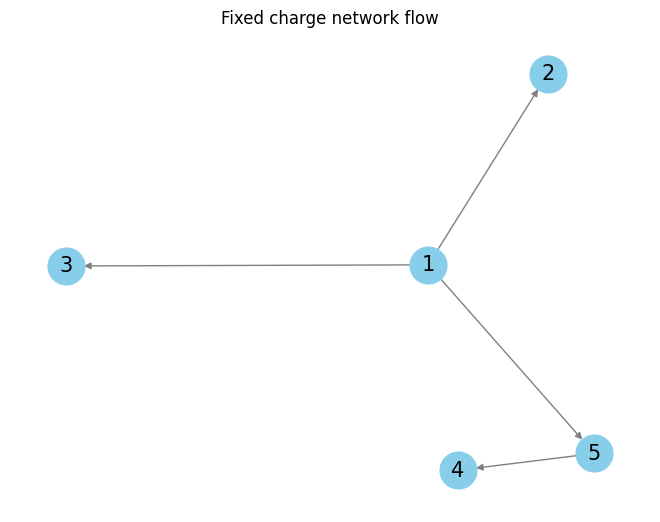

In [ ]:
# Create a directed graph

p.reduce_data()
G = nx.DiGraph()

# Add edges to the graph from the arcs list
G.add_edges_from(p.arcs)

# Draw the graph
pos = nx.spring_layout(G)  # This defines the layout of the graph
nx.draw(G, pos, with_labels=True, node_size=700, node_color='skyblue', font_size=15, width=1, edge_color='gray', arrowstyle='-|>')

plt.title("Fixed charge network flow")
plt.show()

In [ ]:
p.flow_cost

{(1, 2): 28.442331511654345,
 (1, 3): 20.580815751497358,
 (1, 5): 24.4338333254607,
 (5, 4): 39.850868243521305}

### 4.2: Bound Comparison

In [ ]:
# Experiment showing the quality of the lower bound on phi

n_values = [15, 30, 50, 75, 100, 125, 150]
n_simulations = 50

# Store results for each method
results = {
    'proposed': {'median': [], 'worst': [], 'best': []},
    'trivial': {'median': [], 'worst': [], 'best': []},
    'strengthened': {'median': [], 'worst': [], 'best': []}
}

for n in n_values:
    print(f"Processing for n = {n} ...")

    # Store gaps for current n for each method
    gaps = {'proposed': [], 'trivial': [], 'strengthened': []}

    for _ in range(n_simulations):
        # Create problem instance
        t1 = t.time()
        p_instance = FCNFP(n, t1)
        p_instance.reduce_data()
        # Compute lower bounds
        lb_proposed = p_instance.compute_improved_lower_bound()
        lb_trivial = -p_instance.demand[1] * min(p_instance.flow_cost.values())

        direct_flow_costs1 = [p_instance.flow_cost[(1, j)] for j in p_instance.nodes_connected_to_root if j > 1]

        if p_instance.nodes_not_connected_to_root:
            direct_flow_costs2 = [p_instance.flow_cost[(i, j)] for i in p_instance.nodes_connected_to_root
                                  for j in p_instance.nodes_not_connected_to_root if (i, j) in p_instance.arcs]
        else:
            direct_flow_costs2 = [0]

        lb_strengthened = -min(direct_flow_costs1) * p_instance.demand[1] + min(direct_flow_costs2) * sum(p_instance.demand[j] for j in p_instance.nodes_not_connected_to_root)

        # Solve the problem
        solver = FCNFPSolver(p_instance)
        solver.build_model()
        solver.solve()

        # Get the objective value
        obj_val = solver.get_objective_value()

        if obj_val is not None:
            gaps['proposed'].append(lb_proposed / obj_val)
            gaps['trivial'].append(lb_trivial / obj_val)
            gaps['strengthened'].append(lb_strengthened / obj_val)

    for method, values in gaps.items():
        results[method]['median'].append(np.median(values))
        results[method]['worst'].append(max(values))
        results[method]['best'].append(min(values))

In [ ]:
plt.figure(figsize=(12, 6))

# Colorblind-friendly palette
colors = {'proposed': '#E69F00', 'trivial': '#56B4E9', 'strengthened': '#009E73'}

for method, color in colors.items():
    # Ribbon around the median
    plt.fill_between(n_values, results[method]['best'], results[method]['worst'], color=color, alpha=0.4)

    # Plotting lines for median with thicker line
    plt.plot(n_values, results[method]['median'], linestyle='-', color=color, label=f'{method.capitalize()}', linewidth=2.5)

# Title and labels
#plt.title("Gap Between Lower Bound and Objective Value", fontsize=18, fontweight='bold')
plt.xlabel("Number of Nodes (n_nodes)", fontweight='bold', fontsize=18)
plt.ylabel("Gap", fontweight='bold', fontsize=18)

# Bold legend labels
legend = plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize = 14)
for text in legend.get_texts():
    text.set_fontweight('bold')

# Grid style and axis width
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)

plt.tight_layout()
plt.show()

### 4.3 Computation Time Comparison

In [ ]:
# Comparison of computation times:
methods = ['trivial', 'strengthened', 'proposed']
computation_times = {method: {'median': [], 'best': [], 'worst': []} for method in methods}

for n in n_values:
    print(f"Processing n = {n}")
    times_for_current_n = {method: [] for method in methods}

    for _ in range(n_simulations):
        p_instance = FCNFP(n, t.time())
        p_instance.reduce_data()
        # Trivial method
        start_time = t.time()
        trivial_lower_bound = p_instance.demand[1] * min(p_instance.flow_cost.values())
        elapsed_time = t.time() - start_time
        times_for_current_n['trivial'].append(elapsed_time)

        # Strengthened method
        start_time = t.time()
        direct_flow_costs1 = [p_instance.flow_cost[(1, j)] for j in p_instance.nodes_connected_to_root if j > 1]
        if p_instance.nodes_not_connected_to_root:
            direct_flow_costs2 = [p_instance.flow_cost[(i, j)] for i in p_instance.nodes_connected_to_root
                                  for j in p_instance.nodes_not_connected_to_root if (i,j) in p_instance.arcs]
        else:
            direct_flow_costs2 = [0]
        strengthened_bound2 = -min(direct_flow_costs1) * p_instance.demand[1] + min(direct_flow_costs2) * sum(p_instance.demand[j] for j in p_instance.nodes_not_connected_to_root)
        elapsed_time = t.time() - start_time
        times_for_current_n['strengthened'].append(elapsed_time)

        # Proposed method
        start_time = t.time()
        proposed_lower_bound = p_instance.compute_improved_lower_bound()
        elapsed_time = t.time() - start_time
        times_for_current_n['proposed'].append(elapsed_time)

    for method in methods:
        avg_time = np.median(times_for_current_n[method])
        worst_time = max(times_for_current_n[method])
        best_time = min(times_for_current_n[method])

        computation_times[method]['median'].append(avg_time)
        computation_times[method]['worst'].append(worst_time)
        computation_times[method]['best'].append(best_time)

In [ ]:
plt.figure(figsize=(12, 6))
colors = {'proposed': '#E69F00', 'trivial': '#56B4E9', 'strengthened': '#009E73'}

for method, color in colors.items():
    # Ribbon around the median
    plt.fill_between(n_values, computation_times[method]['best'], computation_times[method]['worst'], color=color, alpha=0.4)
    # Plotting lines for median with thicker line
    plt.plot(n_values, computation_times[method]['median'], linestyle='-', color=color, label=f'{method.capitalize()}', linewidth=2.5)

plt.xlabel("Number of Nodes (n_nodes)", fontweight='bold', fontsize=14)
plt.ylabel("Time (seconds) (log scale)", fontweight='bold', fontsize=14)  # Updated y-axis label
plt.grid(True)
legend = plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=14)
for text in legend.get_texts():
    text.set_fontweight('bold')
plt.tight_layout()
plt.yscale("log")
plt.show()

### 4.4: Solver/Heuristic Comparison

In [ ]:
# Experiment Parameters
n_values = [10, 20, 30, 50, 75, 100, 125, 175, 225, 275, 300]
repeats = 20

overall_results = {
    'runtime_ratio': {'worst': [], 'median': [], 'best': []},
    'objective_ratio': {'worst': [], 'median': [], 'best': []},
    'solver_runtimes': {'worst': [], 'median': [], 'best': []},
    'heuristic_runtimes': {'worst': [], 'median': [], 'best': []}
}

for n in n_values:
    print(f'Grinding... {n}')
    runtime_ratios = []
    objective_ratios = []
    solver_runtimes_list = []
    heuristic_runtimes_list = []

    for i in range(repeats):
        if ((i+1) % 5 == 0 or (i+1) == 1) and n >= 100:
            print(f'currently at: {i+1}')
        p = FCNFP(n, t.time())
        p.reduce_data()

        # Solver
        t1 = t.time()
        solver = FCNFPSolver(p)
        solver.build_model()
        solver.solve()
        solver_objective_val = solver.get_objective_value()
        t2 = t.time()
        solver_runtime = t2-t1

        # Heuristic
        t3 = t.time()
        heuristic_val, _ = p.heuristic_solution()
        t4 = t.time()
        heuristic_runtime = t4-t3

        # Compute ratios and store absolute runtimes
        runtime_ratios.append(solver_runtime/heuristic_runtime)
        objective_ratios.append(heuristic_val/solver_objective_val)
        solver_runtimes_list.append(solver_runtime)
        heuristic_runtimes_list.append(heuristic_runtime)

    # Store results
    overall_results['runtime_ratio']['worst'].append(max(runtime_ratios))
    overall_results['runtime_ratio']['median'].append(np.median(runtime_ratios))
    overall_results['runtime_ratio']['best'].append(min(runtime_ratios))

    overall_results['objective_ratio']['worst'].append(max(objective_ratios))
    overall_results['objective_ratio']['median'].append(np.median(objective_ratios))
    overall_results['objective_ratio']['best'].append(min(objective_ratios))

    overall_results['solver_runtimes']['worst'].append(max(solver_runtimes_list))
    overall_results['solver_runtimes']['median'].append(np.median(solver_runtimes_list))
    overall_results['solver_runtimes']['best'].append(min(solver_runtimes_list))

    overall_results['heuristic_runtimes']['worst'].append(max(heuristic_runtimes_list))
    overall_results['heuristic_runtimes']['median'].append(np.median(heuristic_runtimes_list))
    overall_results['heuristic_runtimes']['best'].append(min(heuristic_runtimes_list))
print("Done")


In [ ]:
# Plotting Runtime Ratios
plt.figure(figsize=(12, 6))

method = 'runtime_ratio'
color = '#E69F00'

plt.fill_between(n_values, overall_results[method]['best'], overall_results[method]['worst'], color=color, alpha=0.4)
plt.plot(n_values, overall_results[method]['median'], linestyle='-', color=color, label=f'Median Runtime Ratio', linewidth=2.5)

plt.xlabel("Number of Nodes (n_nodes)", fontweight='bold', fontsize=18)
plt.ylabel("Runtime Ratio", fontweight='bold', fontsize=18)

plt.grid(True)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.yscale("log")
plt.tight_layout()
plt.show()

# Plotting Objective Value Ratios
plt.figure(figsize=(12, 6))

method = 'objective_ratio'
color = '#56B4E9'

plt.fill_between(n_values, overall_results[method]['best'], overall_results[method]['worst'], color=color, alpha=0.4)
plt.plot(n_values, overall_results[method]['median'], linestyle='-', color=color, label=f'Median Objective Value Ratio', linewidth=2.5)

plt.xlabel("Number of Nodes (n_nodes)", fontweight='bold', fontsize=18)
plt.ylabel("Objective Value Ratio", fontweight='bold', fontsize=18)

plt.grid(True)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.show()

# Plotting Absolute Runtimes for Solver and Heuristic
plt.figure(figsize=(12, 6))


plt.fill_between(n_values, overall_results['solver_runtimes']['best'], overall_results['solver_runtimes']['worst'], color='#009E73', alpha=0.4)
plt.plot(n_values, overall_results['solver_runtimes']['median'], linestyle='-', color='#009E73', label=f'Median Solver Runtime', linewidth=2.5)

plt.fill_between(n_values, overall_results['heuristic_runtimes']['best'], overall_results['heuristic_runtimes']['worst'], color='#D55E00', alpha=0.4)
plt.plot(n_values, overall_results['heuristic_runtimes']['median'], linestyle='-', color='#D55E00', label=f'Median Heuristic Runtime', linewidth=2.5)

plt.xlabel("Number of Nodes (n_nodes)", fontweight='bold', fontsize=18)
plt.ylabel("Absolute Runtime (seconds) (log scale)", fontweight='bold', fontsize=16)

plt.legend(loc="upper left", fontsize = 18)
plt.grid(True)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.yscale("log")
#plt.xscale("log")
plt.tight_layout()
plt.show()